In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("/Users/kassraniroumand/code/aitrading/aitrading/data/eurousd_df_clean_2.csv")


# Convert 'timestamp' to datetime if it's not already
df['timestamp'] = pd.to_datetime(df['datetime'])

# Sort the dataframe by timestamp to ensure correct operations
df = df.sort_values(by='timestamp')
# Calculate the target variable by comparing the current price to the next
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)
# Time-based features (example: part of the day)
df['hour'] = df['timestamp'].dt.hour
df['part_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

df['day_of_week'] = df['timestamp'].dt.dayofweek
# Convert day of week to cyclic features
df['sin_day'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_week'] / 7)


df['price_change_5_intervals'] = df['close'].diff(periods=5)
# Rolling window features (example: rolling average over the last 5 intervals)
df['rolling_avg_price_10_intervals'] = df['close'].rolling(window=5).mean()
df['rolling_avg_price_10_close_intervals'] = df['low'].rolling(window=5).mean()
# Drop any rows with NaN values created by shifts and rolling functions
df.dropna(inplace=True)

df['ma_30m'] = df['close'].rolling(window=5).mean()  # 1-hour MA
df['ma_24h'] = df['close'].rolling(window=12).mean()  # 24-hour MA

df['ema_30min'] = df['close'].ewm(span=5, adjust=False).mean()  # 1-hour EMA
df['ema_24h'] = df['close'].ewm(span=12, adjust=False).mean()  # 24-hour EMA

def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['rsi'] = calculate_rsi(df['close'], window=5)
df.dropna(inplace=True)

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Calculate indices for splits
total_samples = len(df)
train_end = int(total_samples * train_ratio)
validation_end = int(train_end + total_samples * validation_ratio)

# Split the dataset
train_data = df.iloc[:train_end]
validation_data = df.iloc[train_end:validation_end]
test_data = df.iloc[validation_end:]


X_train, y_train = train_data.drop(['target', 'timestamp', 'hour'], axis=1), train_data['target']
X_val, y_val = validation_data.drop(['target', 'timestamp', 'hour'], axis=1), validation_data['target']
X_test, y_test = test_data.drop(['target', 'timestamp', 'hour'], axis=1), test_data['target']


print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Normalize numerical features, replacing 'price' with 'close'
scaler = StandardScaler()
# numeric_features = ['close', 'price_change_5_intervals', 'rolling_avg_price_5_intervals']  # Adjust feature names as needed
numeric_features = [
    'close',
                    'price_change_5_intervals',
                    'rolling_avg_price_10_close_intervals',
                    'rolling_avg_price_10_intervals',
                    'sin_day',
                    'cos_day',
                    # 'ma_30min',
                      'ma_24h',
                  'ema_30min',
                  'ema_24h',
                    'rsi'
                    ]  # Adjust feature names as needed
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
categorical_features = ['part_of_day']  # Ensure this is present or adjust accordingly
# categorical_features = ['part_of_day']  # Ensure this is present or adjust accordingly
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])

# Concatenate encoded categorical features back with numerical features
X_train_preprocessed = np.concatenate((X_train[numeric_features].values, X_train_encoded), axis=1)
X_val_preprocessed = np.concatenate((X_val[numeric_features].values, X_val_encoded), axis=1)
X_test_preprocessed = np.concatenate((X_test[numeric_features].values, X_test_encoded), axis=1)

X_train_reshaped = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
X_test_reshaped = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))
X_val_reshaped = X_val_preprocessed.reshape((X_val_preprocessed.shape[0], 1, X_val_preprocessed.shape[1]))
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_val_categorical = to_categorical(y_val)


Training set size: 125771
Validation set size: 26951
Test set size: 26952


/Users/kassraniroumand/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


NameError: name 'to_categorical' is not defined

In [ ]:


# Display the first few rows to inspect the new features
# df

In [68]:
# Define split ratios


In [69]:
from keras.src.layers import Bidirectional
from keras.src.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [71]:
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the LSTM model
# Assuming X_train_reshaped and y_train_categorical are properly defined

model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh'), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.5))

# Following LSTM layers should also return sequences if they're not the last LSTM layer
# In this case, the second LSTM layer should not return sequences as it's followed by Dense layers
model.add(GRU(128, return_sequences=False, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

# Removed the third LSTM for simplification as its input shape would be incompatible without return_sequences=True in the previous LSTM layer
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))  # Use 'sigmoid' for binary, 'softmax' for multi-class

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Setup callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.01)

# Train the model
history = model.fit(
    X_train_reshaped,
    y_train_categorical, 
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_categorical),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)


# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Compile the model

# Train the model
# history = model.fit(X_train_reshaped, y_train_categorical, epochs=100, batch_size=32, validation_ratio=0.2, verbose=1)
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.001)

# history = model.fit(
#     X_train_reshaped,
#     y_train_categorical, 
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_val_reshaped,y_val_categorical),
#     verbose=1,
#     callbacks=[early_stopping, reduce_lr]
# )

Epoch 1/100


/Users/kassraniroumand/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3931/3931 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.5083 - loss: 0.7152 - val_accuracy: 0.5114 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/100
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.5099 - loss: 0.6930 - val_accuracy: 0.5114 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 3/100
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.5109 - loss: 0.6930 - val_accuracy: 0.5114 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 4/100
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.5116 - loss: 0.6929 - val_accuracy: 0.5114 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 5/100
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.5108 - loss: 0.6929 - val_accuracy: 0.5114 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 6/100
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.5115 - loss: 0.6929 - val_accuracy: 0.5114 - val_loss: 0.6929 - learning_rate: 0.0010


In [ ]:
model.save('model.h5')

In [ ]:
# save the model 


In [72]:
from sklearn.utils.class_weight import compute_class_weight
# Assuming y_train is your labels array for the training data
# And it's a binary classification problem with classes 0 and 1
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {classes[i]: weight for i, weight in enumerate(class_weights)}

print(class_weights_dict)

{0: 0.9787169470686193, 1: 1.0222292662310217}


In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dropout, Dense, Embedding, GRU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2

model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh'), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.5))
model.add(GRU(128, return_sequences=False, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary, 'softmax' for multi-class

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.0001)

# Assume X_train, y_train, X_val, and y_val are defined
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),
                    verbose=1, callbacks=[early_stopping, reduce_lr], class_weight=class_weights_dict)


/Users/kassraniroumand/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'class_weights_dict' is not defined

In [40]:
X_train_reshaped[0]

array([[ 1.32748582, -7.55309829,  1.32889357,  1.32864225,  0.92354213,
         0.82552316,  1.89476093,  1.43433739,  1.91600339, -1.82739179,
         0.        ,  0.        ,  1.        ]])

In [24]:
# Evaluate the model
_, accuracy = model.evaluate(X_test_reshaped, y_test_categorical, verbose=0)
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.51


In [25]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 1, 512)         │       552,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,644,232 (10.09 MB)

 Trainable params: 881,410 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,762,822 (6.72 MB)

In [17]:
from matplotlib import pyplot as plt

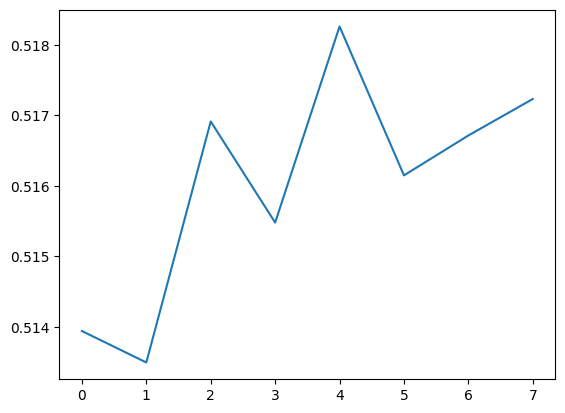

In [99]:
plt.plot(history.history['accuracy'], label='train')

841/841 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step


(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
         3.000e+00, 5.000e+00, 1.300e+01, 4.000e+01, 6.900e+01, 5.600e+01,
         4.100e+01, 5.900e+01, 5.400e+01, 1.170e+02, 1.890e+02, 1.970e+02,
         2.210e+02, 2.320e+02, 2.290e+02, 2.770e+02, 3.590e+02, 4.690e+02,
         4.390e+02, 4.120e+02, 4.640e+02, 4.710e+02, 4.400e+02, 5.430e+02,
         4.460e+02, 4.660e+02, 4.260e+02, 3.920e+02, 4.070e+02, 3.350e+02,
         3.260e+02, 3.320e+02, 3.080e+02, 2.780e+02, 2.770e+02, 2.390e+02,
         2.480e+02, 2.940e+02, 2.670e+02, 2.890e+02, 3.180e+02, 3.210e+02,
         3.300e+02, 3.430e+02, 3.880e+02, 4.190e+02, 4.640e+02, 6.790e+02,
         9.460e+02, 1.043e+03, 1.338e+03, 1.035e+03, 1.086e+03, 1.506e+03,
         1.305e+03, 8.770e+02, 5.340e+02, 6.100e+02, 7.870e+02, 5.540e+02,
         3.180e+02, 1.250

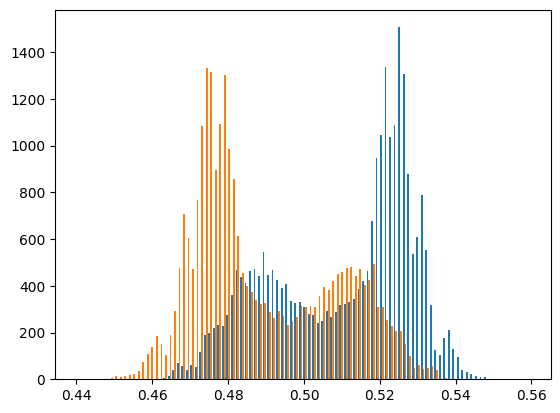

In [100]:
plt.hist(model.predict(X_test_reshaped),bins=100)

841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(array([[14973.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0., 11938.],
        [25153.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         

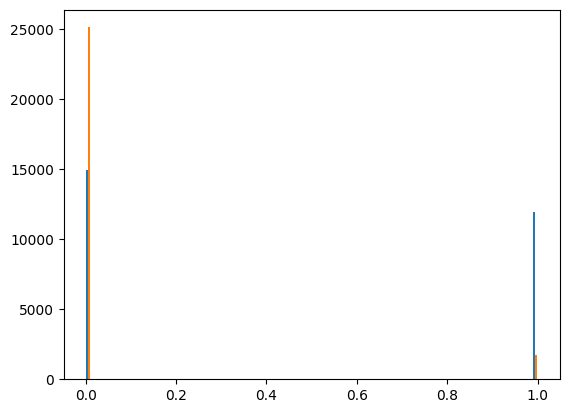

In [106]:
plt.hist(model.predict(X_test_reshaped) > 0.52,bins=100)

841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


(array([[21594.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,  5317.],
        [10878.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         

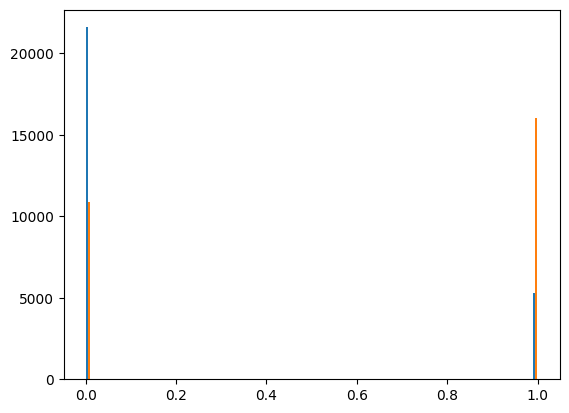

In [105]:
plt.hist(model.predict(X_test_reshaped) <  0.49,bins=100)

In [104]:
len(pd.DataFrame(model.predict(X_test_reshaped)))

841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


26911

In [ ]:
len(X_test_reshaped)

In [78]:
pred = pd.DataFrame(model.predict(X_test_reshaped))

1107/1107 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step


In [ ]:
pred[pred[0] > 0.52]

In [ ]:
pred[pred[1] > 0.52]

In [ ]:
pred

In [85]:
import glob
import os
import pathlib
import time
import pickle

from colorama import Fore, Style
from tensorflow import keras

from aitrading import params


# from aitrading.params import *

def save_model(model: keras.Model = None) -> None:
    """
    Persist trained model locally on the hard drive at f"{LOCAL_REGISTRY_PATH}/models/{timestamp}.h5"
    - if MODEL_TARGET='gcs', also persist it in your bucket on GCS at "models/{timestamp}.h5" --> unit 02 only
    - if MODEL_TARGET='mlflow', also persist it on MLflow instead of GCS (for unit 0703 only) --> unit 03 only
    """

    timestamp = time.strftime("%Y%m%d-%H%M%S")

    # Save model locally
    model_path = os.path.join(params.LOCAL_PATH, "models", f"{timestamp}.h5")
    model.save(model_path)

    print("✅ Model saved locally")
    return None

In [86]:
save_model(model)

AttributeError: module 'aitrading.params' has no attribute 'LOCAL_PATH'